# Domain-Driven Ensemble Learning for Alzheimer's Prediction

This notebook demonstrates a domain-driven ensemble approach for predicting cognitive decline using social determinants of health. The key innovation is splitting features into meaningful domains (demographics, social, health, economic) and training specialized models for each group.

## Table of Contents
1. Introduction
2. Setup and Data Loading
3. Feature Engineering
4. Ensemble Model Implementation
5. Results and Analysis

## Introduction

The Mexican Health and Aging Study (MHAS) provides rich longitudinal data about social determinants of health. Rather than treating all features equally, we:
1. Group features by domain expertise
2. Create specialized models for each domain
3. Combine predictions using weighted averaging

### Why this approach?
- Different feature groups may benefit from different model architectures
- Enables domain-specific feature engineering
- Provides better interpretability by domain
- Allows for analyzing relative importance of different domains

In [1]:
# Import required libraries
import pandas as pd
import numpy as np
from pathlib import Path
import lightgbm as lgb
import xgboost as xgb
from sklearn.model_selection import KFold
from sklearn.metrics import mean_squared_error
from sklearn.preprocessing import LabelEncoder
import matplotlib.pyplot as plt
import seaborn as sns
from typing import List, Dict

# Set random seed for reproducibility
np.random.seed(42)

## Setup and Data Loading

First, let's create our feature encoder to handle categorical variables:

In [2]:
class FeatureEncoder:
    """Handles encoding of categorical features"""
    
    def __init__(self):
        self.label_encoders = {}
        self.numeric_medians = {}
        self.categorical_modes = {}
        self.columns_to_skip = ['uid']  # Columns to preserve as-is
    
    def _is_numeric_compatible(self, series: pd.Series) -> bool:
        """Check if series can be converted to numeric"""
        numeric_count = pd.to_numeric(series, errors='coerce').notna().sum()
        return numeric_count / len(series) > 0.5
    
    def fit_transform(self, df: pd.DataFrame) -> pd.DataFrame:
        """Fit and transform features"""
        df = df.copy()
        
        # Store columns to skip
        skip_cols = {}
        for col in self.columns_to_skip:
            if col in df.columns:
                skip_cols[col] = df[col].copy()
                df = df.drop(col, axis=1)
        
        # First pass: identify numeric and categorical columns
        numeric_cols = []
        categorical_cols = []
        
        for col in df.columns:
            if self._is_numeric_compatible(df[col]):
                numeric_cols.append(col)
            else:
                categorical_cols.append(col)
        
        print(f"\nIdentified {len(numeric_cols)} numeric and {len(categorical_cols)} categorical columns")
        
        # Handle numeric columns
        for col in numeric_cols:
            df[col] = pd.to_numeric(df[col], errors='coerce')
            self.numeric_medians[col] = df[col].median()
            df[col] = df[col].fillna(self.numeric_medians[col])
        
        # Handle categorical columns
        for col in categorical_cols:
            df[col] = df[col].astype(str)
            self.categorical_modes[col] = df[col].mode().iloc[0]
            df[col] = df[col].replace('nan', self.categorical_modes[col])
            
            self.label_encoders[col] = LabelEncoder()
            self.label_encoders[col].fit(df[col].unique())
            df[col] = self.label_encoders[col].transform(df[col])
        
        # Restore skipped columns
        for col, values in skip_cols.items():
            df[col] = values
        
        return df

In [3]:
# Load and prepare the data
def load_data():
    """Load and prepare the competition data"""
    data_dir = Path('../data/raw')
    
    train_features = pd.read_csv(data_dir / 'train_features.csv')
    test_features = pd.read_csv(data_dir / 'test_features.csv')
    train_labels = pd.read_csv(data_dir / 'train_labels.csv')
    
    return train_features, test_features, train_labels

train_features, test_features, train_labels = load_data()

## Feature Engineering

We create several types of engineered features based on domain knowledge:

In [4]:
def create_health_composites(df: pd.DataFrame) -> pd.DataFrame:
    """Create health-related composite features"""
    df = df.copy()
    
    # Health indicators
    health_indicators = ['n_adl', 'n_iadl', 'n_depr', 'n_illnesses']
    
    for suffix in ['_03', '_12']:
        valid_cols = [f"{col}{suffix}" for col in health_indicators 
                     if f"{col}{suffix}" in df.columns]
        
        if valid_cols:
            # Convert to numeric and handle missing values
            for col in valid_cols:
                df[col] = pd.to_numeric(df[col], errors='coerce').fillna(0)
            
            # Create normalized versions
            for col in valid_cols:
                df[f'{col}_norm'] = (df[col] - df[col].mean()) / df[col].std()
            
            # Combine normalized indicators
            df[f'health_score{suffix}'] = df[[f'{col}_norm' 
                for col in valid_cols]].mean(axis=1)
    
    return df

In [5]:
def _convert_to_numeric(series: pd.Series) -> pd.Series:
    """Convert series to numeric, handling missing values"""
    return pd.to_numeric(series, errors='coerce').fillna(0)

In [6]:
def create_social_features(df: pd.DataFrame) -> pd.DataFrame:
    """Create social engagement features"""
    df = df.copy()
    
    social_cols = {
        '12': ['rrfcntx_m_12', 'rsocact_m_12', 'n_living_child_12'],
        '03': ['n_living_child_03']
    }
    
    for year, cols in social_cols.items():
        valid_cols = [col for col in cols if col in df.columns]
        if valid_cols:
            # Convert columns to numeric
            numeric_cols = []
            for col in valid_cols:
                df[f'{col}_numeric'] = _convert_to_numeric(df[col])
                numeric_cols.append(f'{col}_numeric')
            
            # Calculate social score using numeric versions
            df[f'social_score_{year}'] = df[numeric_cols].mean(axis=1)
    
    return df

In [7]:
def create_economic_features(df: pd.DataFrame) -> pd.DataFrame:
    """Create economic-related features"""
    df = df.copy()
    
    economic_cols = ['hincome', 'hinc_business', 'hinc_rent', 'hinc_assets']
    
    for suffix in ['_03', '_12']:
        valid_cols = [f"{col}{suffix}" for col in economic_cols 
                     if f"{col}{suffix}" in df.columns]
        
        if valid_cols:
            # Convert to numeric and handle missing values
            for col in valid_cols:
                df[col] = _convert_to_numeric(df[col])
            
            # Calculate total income
            df[f'total_income{suffix}'] = df[valid_cols].sum(axis=1)
            
            # Calculate income diversity (number of non-zero sources)
            df[f'income_sources{suffix}'] = (df[valid_cols] > 0).sum(axis=1)
    
    return df

In [8]:
def engineer_features(df: pd.DataFrame) -> pd.DataFrame:
    """Apply all feature engineering steps"""
    print("Starting feature engineering...")
    print(f"Initial shape: {df.shape}")
    
    # Create composite features
    df = create_health_composites(df)
    print("Created health composites")
    
    df = create_social_features(df)
    print("Created social features")
    
    df = create_economic_features(df)
    print("Created economic features")
    
    print(f"Final shape: {df.shape}")
    return df

In [9]:
# Apply feature engineering to training and test data
train_features = engineer_features(train_features)
test_features = engineer_features(test_features)

# Display feature info
print("\nFeature types after engineering:")
print(train_features.dtypes.value_counts())
print("\nSample of engineered features:")
print(train_features.describe())

Starting feature engineering...
Initial shape: (3276, 184)
Created health composites
Created social features
Created economic features
Final shape: (3276, 204)
Starting feature engineering...
Initial shape: (819, 184)
Created health composites
Created social features
Created economic features
Final shape: (819, 204)

Feature types after engineering:
float64    158
object      44
int64        2
Name: count, dtype: int64

Sample of engineered features:
          n_mar_03  migration_03  adl_dress_03  adl_walk_03  adl_bath_03  \
count  2222.000000   2241.000000   2105.000000  2235.000000  2235.000000   
mean      1.134113      0.099063      0.041805     0.017002     0.007159   
std       0.482953      0.298813      0.200191     0.129308     0.084325   
min       0.000000      0.000000      0.000000     0.000000     0.000000   
25%       1.000000      0.000000      0.000000     0.000000     0.000000   
50%       1.000000      0.000000      0.000000     0.000000     0.000000   
75%       1.0

## Ensemble Model Implementation 

Our ensemble model consists of specialized models for different feature groups:


In [10]:
class FeatureGroupModel:
    """Base class for feature group-specific models"""
    
    def __init__(self, name: str, features: List[str], model_type: str = 'lgb'):
        self.name = name
        self.features = features
        self.model_type = model_type
        self.models = []
        
    def train(self, X: pd.DataFrame, y: pd.Series, n_splits: int = 5) -> float:
        """Train model using k-fold cross-validation"""
        X = X[self.features].copy()
        scores = []
        
        print(f"\nTraining {self.name} model ({self.model_type})...")
        print(f"Using features: {self.features}")
        
        kf = KFold(n_splits=n_splits, shuffle=True, random_state=42)
        
        for fold, (train_idx, val_idx) in enumerate(kf.split(X)):
            print(f"\nFold {fold + 1}")
            X_train, X_val = X.iloc[train_idx], X.iloc[val_idx]
            y_train, y_val = y.iloc[train_idx], y.iloc[val_idx]
            
            if self.model_type == 'lgb':
                model = self._train_lgb(X_train, y_train, X_val, y_val)
            else:  # xgb
                model = self._train_xgb(X_train, y_train, X_val, y_val)
            
            self.models.append(model)
            
            # Calculate fold score
            val_pred = self.predict_with_model(model, X_val)
            score = np.sqrt(mean_squared_error(y_val, val_pred))
            scores.append(score)
            print(f"Fold {fold + 1} RMSE: {score:.4f}")
            
        mean_score = np.mean(scores)
        print(f"\nMean CV RMSE: {mean_score:.4f}")
        return mean_score
    
    def _train_lgb(self, X_train, y_train, X_val, y_val):
        """Train LightGBM model"""
        train_data = lgb.Dataset(X_train, label=y_train)
        val_data = lgb.Dataset(X_val, label=y_val)
        
        params = {
            'objective': 'regression',
            'metric': 'rmse',
            'learning_rate': 0.05,
            'num_leaves': 31,
            'feature_fraction': 0.8,
            'bagging_fraction': 0.8,
            'bagging_freq': 5,
            'verbose': -1
        }
        
        model = lgb.train(
            params,
            train_data,
            num_boost_round=1000,
            valid_sets=[train_data, val_data],
            callbacks=[
                lgb.early_stopping(stopping_rounds=100),
                lgb.log_evaluation(period=100)
            ]
        )
        
        return model
    
    def _train_xgb(self, X_train, y_train, X_val, y_val):
        """Train XGBoost model"""
        dtrain = xgb.DMatrix(X_train, label=y_train)
        dval = xgb.DMatrix(X_val, label=y_val)
        
        params = {
            'objective': 'reg:squarederror',
            'eval_metric': 'rmse',
            'max_depth': 6,
            'learning_rate': 0.05,
            'subsample': 0.8,
            'colsample_bytree': 0.8
        }
        
        model = xgb.train(
            params,
            dtrain,
            num_boost_round=1000,
            early_stopping_rounds=100,
            evals=[(dtrain, 'train'), (dval, 'val')],
            verbose_eval=100
        )
        
        return model
    
    def predict_with_model(self, model, X):
        """Make predictions with a single model"""
        if self.model_type == 'lgb':
            return model.predict(X)
        else:  # xgb
            return model.predict(xgb.DMatrix(X))
    
    def predict(self, X: pd.DataFrame) -> np.ndarray:
        """Make predictions using all trained models"""
        X = X[self.features].copy()
        predictions = np.zeros(len(X))
        
        for model in self.models:
            predictions += self.predict_with_model(model, X)
        
        return predictions / len(self.models)

In [11]:
class EnsembleModel:
    """Ensemble of feature group models"""
    
    def __init__(self, feature_groups: Dict[str, List[str]]):
        self.feature_groups = feature_groups
        self.models = {}
        self.weights = None
    
    def train(self, X: pd.DataFrame, y: pd.Series) -> float:
        """Train all models and optimize weights"""
        print("Training ensemble models...")
        predictions = {}
        scores = {}
        
        for group_name, features in self.feature_groups.items():
            print(f"\nTraining {group_name} group...")
            # Verify features exist
            missing_features = [f for f in features if f not in X.columns]
            if missing_features:
                print(f"Warning: Missing features in {group_name}: {missing_features}")
                continue
            
            model = FeatureGroupModel(
                name=group_name,
                features=features,
                model_type='lgb' if group_name in ['demographics', 'health'] else 'xgb'
            )
            
            score = model.train(X, y)
            self.models[group_name] = model
            scores[group_name] = score
        
        # Calculate weights based on scores
        total = sum(1/score for score in scores.values())
        self.weights = {name: (1/score)/total for name, score in scores.items()}
        
        # Print weights
        print("\nModel weights:")
        for name, weight in self.weights.items():
            print(f"{name}: {weight:.4f}")
        
        return np.mean(list(scores.values()))
    
    def predict(self, X: pd.DataFrame) -> np.ndarray:
        """Make predictions using weighted ensemble"""
        predictions = np.zeros(len(X))
        
        for group_name, model in self.models.items():
            predictions += model.predict(X) * self.weights[group_name]
        
        return predictions

In [12]:
feature_groups = {
    'demographics': [
        'edu_gru_12_numeric', 'edu_gru_03_numeric',
        'age_12_numeric', 'age_03_numeric',
        'n_living_child_12_numeric'
    ],
    'social': [
        'social_score_12',
        'rrfcntx_m_12_numeric',
        'rsocact_m_12_numeric'
    ],
    'health': [
        'health_score_12',
        'n_depr_12',
        'n_illnesses_12'
    ],
    'economic': [
        'total_income_12',
        'income_sources_12',
        'hincome_12_numeric'
    ]
}

In [13]:
# Train the ensemble
encoder = FeatureEncoder()
X_encoded = encoder.fit_transform(train_features)
ensemble = EnsembleModel(feature_groups)
score = ensemble.train(X_encoded, train_labels['composite_score'])


Identified 154 numeric and 49 categorical columns
Training ensemble models...

Training demographics group...

Training social group...

Training social model (xgb)...
Using features: ['social_score_12', 'rrfcntx_m_12_numeric', 'rsocact_m_12_numeric']

Fold 1
[0]	train-rmse:60.89658	val-rmse:58.74054
[100]	train-rmse:60.89663	val-rmse:58.73974
[200]	train-rmse:60.89675	val-rmse:58.74314
[300]	train-rmse:60.89658	val-rmse:58.74104
[353]	train-rmse:60.89664	val-rmse:58.73964
Fold 1 RMSE: 58.7396

Fold 2
[0]	train-rmse:60.58019	val-rmse:60.05265


/tmp/ipykernel_15845/1484931247.py:56: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df[col] = values


[100]	train-rmse:60.58037	val-rmse:60.04693
[200]	train-rmse:60.58014	val-rmse:60.05886
[202]	train-rmse:60.58016	val-rmse:60.05495
Fold 2 RMSE: 60.0552

Fold 3
[0]	train-rmse:60.38661	val-rmse:60.81295
[100]	train-rmse:60.38658	val-rmse:60.81422
[200]	train-rmse:60.38666	val-rmse:60.81947
[224]	train-rmse:60.38659	val-rmse:60.81397
Fold 3 RMSE: 60.8150

Fold 4
[0]	train-rmse:59.75907	val-rmse:63.23879
[100]	train-rmse:59.75939	val-rmse:63.23940
[103]	train-rmse:59.75936	val-rmse:63.23936
Fold 4 RMSE: 63.2394

Fold 5
[0]	train-rmse:60.70891	val-rmse:59.55733
[100]	train-rmse:60.70900	val-rmse:59.54682
[195]	train-rmse:60.70892	val-rmse:59.55384
Fold 5 RMSE: 59.5538

Mean CV RMSE: 60.4806

Training health group...

Training health model (lgb)...
Using features: ['health_score_12', 'n_depr_12', 'n_illnesses_12']

Fold 1
Training until validation scores don't improve for 100 rounds
[100]	training's rmse: 60.0327	valid_1's rmse: 59.3582
Early stopping, best iteration is:
[1]	training's rms

## Results and Analysis


Let's analyze the performance of our ensemble model:


Model Weights:
social: 0.4998
health: 0.5002


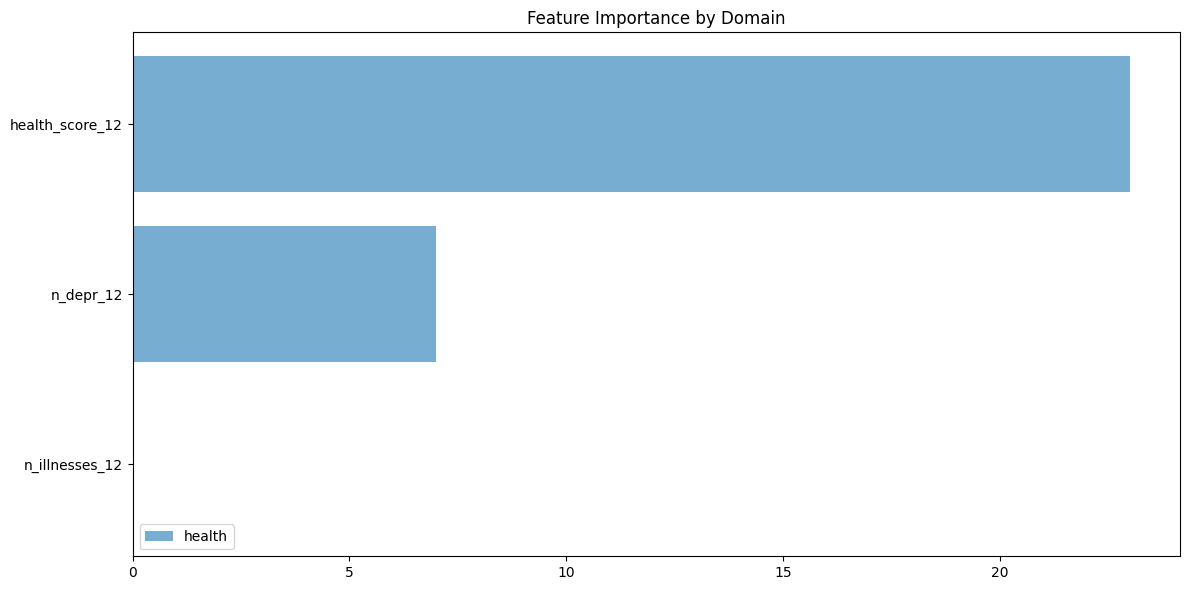

In [14]:
def analyze_results(ensemble: EnsembleModel, X: pd.DataFrame, y: pd.Series):
    """Analyze ensemble performance"""
    # Performance by domain
    print("\nModel Weights:")
    for group, weight in ensemble.weights.items():
        print(f"{group}: {weight:.4f}")
    
    # Feature importance analysis
    plt.figure(figsize=(12, 6))
    for group_name, model in ensemble.models.items():
        if hasattr(model.models[0], 'feature_importance'):
            importance = pd.Series(
                model.models[0].feature_importance(),
                index=model.features
            ).sort_values(ascending=True)
            
            plt.barh(
                importance.index,
                importance.values,
                alpha=0.6,
                label=group_name
            )
    
    plt.title("Feature Importance by Domain")
    plt.legend()
    plt.tight_layout()
    plt.show()

analyze_results(ensemble, X_encoded, train_labels['composite_score'])

## Requirements

In [15]:
print('\n'.join(f'{m.__name__}=={m.__version__}' for m in globals().values() if getattr(m, '__version__', None)))

pandas==2.2.3
numpy==2.2.0
lightgbm==4.5.0
xgboost==2.1.3
seaborn==0.13.2
